# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Questions:
## In this project, i try to answer 2 questions below:

### 1. What factors have a major impact on the use of a offer?

### 2. Is it possible to create a model that predicts whether or not someone will accept an offer based on demographic data?


# Table of Contents

### 1. [Data Understanding](#DataUnderstanding)
### 2. [Data Preprocessing](#DataPreprocessing)
### 3. [Feature Engineering](#FeatureEngineering)
### 4. [Data Modeling](#DataModeling)
### 5. [Conclusion](#Conclusion)

## 1. Data Understanding <a name="DataUnderstanding"></a>

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer 
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

**profile.json**
Rewards program users (17000 users x 5 fields)

* gender: (categorical) M, F, O, or null
* age: (numeric) missing value encoded as 118
* id: (string/hash)
* * became_member_on: (date) format YYYYMMDD
* income: (numeric)

**portfolio.json**
Offers sent during 30-day test period (10 offers x 6 fields)

* reward: (numeric) money awarded for the amount spent
* channels: (list) web, email, mobile, social
* difficulty: (numeric) money required to be spent to receive reward
* duration: (numeric) time for offer to be open, in days
* offer_type: (string) bogo, discount, informational
* id: (string/hash)

**transcript.json**
Event log (306648 events x 4 fields)

* person: (string/hash)
* event: (string) offer received, offer viewed, transaction, offer completed
* value: (dictionary) different values depending on event type
* offer id: (string/hash) not associated with any "transaction"
* amount: (numeric) money spent in "transaction"
* reward: (numeric) money gained from "offer completed"
* time: (numeric) hours after start of test

In [91]:
# import libraries
import pandas as pd
import numpy as np
import math
import json

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [411]:
import zipfile
# unzip data from zip file
with zipfile.ZipFile("data/transcript.zip","r") as zip_ref:
    zip_ref.extract("transcript.json","data")

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Portfolio

In [3]:
# display data
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
# shape
portfolio.shape

(10, 6)

In [5]:
# describe
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
# check for missing value
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

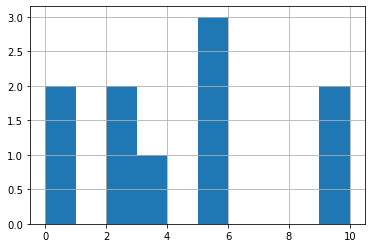

In [401]:
# display the reward distribution
portfolio.reward.hist();

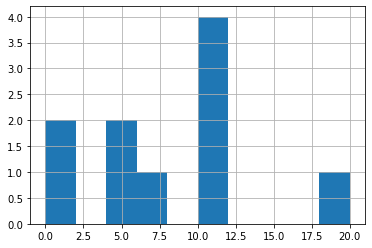

In [402]:
# display the difficulty distribution
portfolio.difficulty.hist();

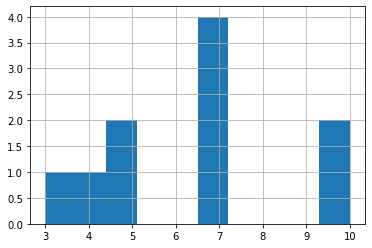

In [403]:
# display the duration distribution
portfolio.duration.hist();

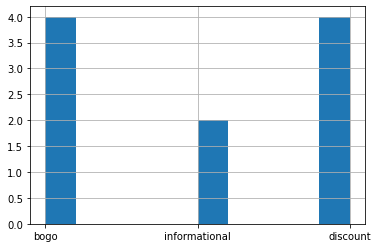

In [405]:
# display the offer_type distribution
portfolio.offer_type.hist();

> We have 3 types of offer: bogo, discount and informational.

> Most of offer open about 6-7  days.

> User need to spend 10-12 (assume it is dollar(USD)) to recevie an offer.

> Most of reward is about 5-6 (assume it is dollar(USD)).

> Data in channels column is inside [] and separated by comma. We should split to multiple columns.

### Profile

In [9]:
# display data
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
# shape
profile.shape

(17000, 5)

In [11]:
# number of unique users
profile.id.nunique()

17000

In [12]:
# describe
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
# We have age outlier here. Let see how many records
profile[profile.age == 118].shape[0]

2175

In [14]:
# check for missing value
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [15]:
# i think that there are 2175 records that missing age, gender, income (Perhaps users didn't provide us)
# let check
profile[profile.age == 118][['gender','income']].isnull().sum()

gender    2175
income    2175
dtype: int64

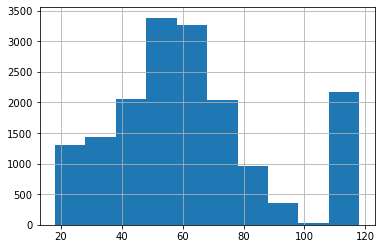

In [406]:
# display the age distribution
profile.age.hist();

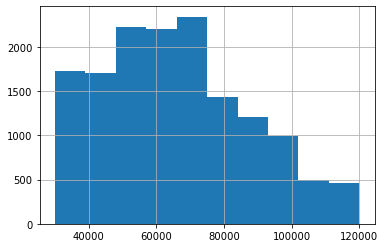

In [407]:
# display the income distribution
profile.income.hist();

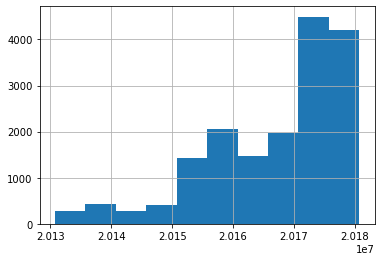

In [409]:
# display the become_member_on distribution
profile.became_member_on.hist();

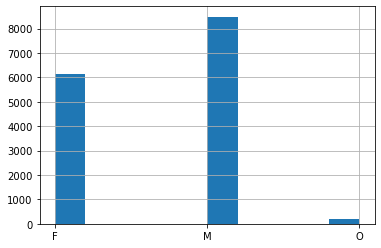

In [18]:
# display gender plot
profile["gender"].hist();

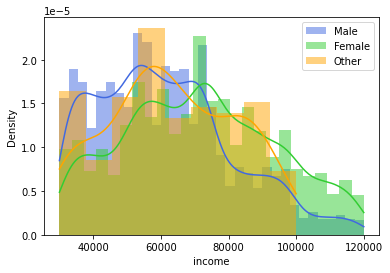

In [19]:
# display gender and income distribution
sns.histplot(profile[profile.gender=='M'].income,label='Male', color = 'royalblue', kde=True, stat="density", linewidth=0)
sns.histplot(profile[profile.gender=='F'].income,label='Female', color = 'limegreen',kde=True, stat="density", linewidth=0)
sns.histplot(profile[profile.gender=='O'].income,label='Other', color = 'orange',kde=True, stat="density", linewidth=0)
plt.legend();
plt.show();

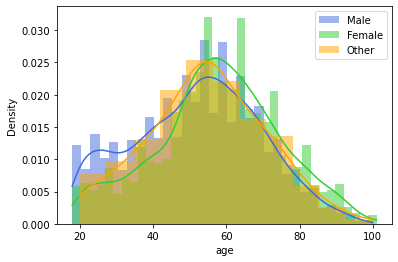

In [20]:
# display gender and age distribution
sns.histplot(profile[profile.gender=='M'].age,label='Male', color = 'royalblue', kde=True, stat="density", linewidth=0)
sns.histplot(profile[profile.gender=='F'].age,label='Female', color = 'limegreen',kde=True, stat="density", linewidth=0)
sns.histplot(profile[profile.gender=='O'].age,label='Other', color = 'orange',kde=True, stat="density", linewidth=0)
plt.legend();
plt.show();

> There are 17000 users, but there are 2175 records that missing value(age, gender, income).

> Member has increased over the years.

> Most of uses are Male an Female, only 212 is Other.

> The distribution of age is nearly normal distribution for all gender (Male, Female and Other).

> The income seems to be similar for all genders.

> We can create new column from became_member_on column. For example: how many days that a user is a member, or extract Year from it.

### Transcript

In [21]:
# display data
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [22]:
# shape
transcript.shape

(306534, 4)

In [23]:
# describe
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


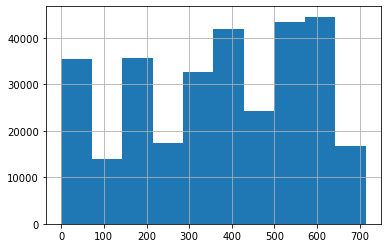

In [24]:
# plot time
transcript.time.hist();

In [25]:
# check for missing value
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [26]:
# number of unique users
transcript.person.nunique()

17000

In [27]:
# How many offers sent to each user.
transcript[transcript.event == 'offer received'].groupby('person').event.count().describe()

count    16994.000000
mean         4.488467
std          1.073047
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          6.000000
Name: event, dtype: float64

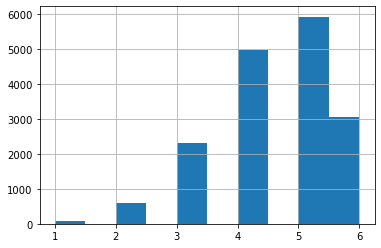

In [28]:
transcript[transcript.event == 'offer received'].groupby('person').event.count().hist();

In [29]:
# check event distribution
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

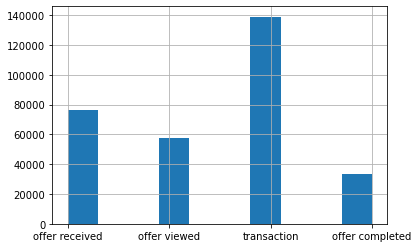

In [30]:
# plot event 
transcript.event.hist();

In [31]:
# offer received
transcript[transcript.event == 'offer received']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576
257883,cb23b66c56f64b109d673d5e56574529,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576


In [32]:
# offer viewed
transcript[transcript.event == 'offer viewed']

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
...,...,...,...,...
306441,d56386cf344c4829bbf420d1895dca37,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714
306450,9b51e8797290403b90d09d864dec4b94,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714
306483,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714
306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714


In [33]:
# transaction
transcript[transcript.event == 'transaction']

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [34]:
# completed
transcript[transcript.event == 'offer completed']

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0
...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714


> The data were collected for about 30 days.

> The number of unique users is same as the profile (17000).

> Each user received about 4-5 offers, maximum is 6.

> We have 4 types of event: offer received, offer viewed, offer completed, transaction

> We have to extract offer id, amout, reward from value column

> The event 'transaction' does't have any offer id associated with it, we have to find a way to fill this value.

> We should combine with Portfolio and Profile data to get offer and user profile information

## 2. Data Preprocessing <a name="DataPreprocessing"></a>

### Portfolio

Split the channels column into 4 columns: web, email, mobile, social. Then drop the channels column

Change id to offer_id

In [35]:
def clean_portfolio(df_portfolio):
    """Clean portfolio data
    inputs:
        df_portfolio (data frame): portfolio data
    outputs:
        df_ret (data frame): cleaned portfolio data
    """
    # make copy
    df_ret = df_portfolio.copy()
    
    # split the channels column into 4 columns: web, email, mobile, social
    new_cols = ['web', 'email', 'mobile', 'social']
    for new_col in new_cols:
        df_ret[new_col] = df_ret['channels'].apply(lambda col_data: 1 if new_col in col_data else 0)
    
    # drop channels
    df_ret.drop(['channels'], axis=1, inplace=True)
    
    # rename the id column
    df_ret.rename(columns={'id': 'offer_id'}, inplace=True)
    
    return df_ret

In [36]:
portfolio_clean = clean_portfolio(portfolio)

In [37]:
portfolio_clean

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


### Profile

There are 2175 records that missing value (age, gender, income). I want to use these columns later, it's about only 12% of 17000 records,  so I think it's ok to drop these records.

Change id to person

In [38]:
def clean_profile(df_profile):
    """Clean profile data
    inputs:
        df_profile (data frame): profile data
    outputs:
        df_ret (data frame): cleaned profile data
    """
    # make copy
    df_ret = df_profile.copy()
    
    # drop missing rows
    df_ret.dropna(inplace=True)
    
    # rename id column
    df_ret.rename(columns={'id':'person'},inplace=True)
    
    return df_ret

In [39]:
profile_clean = clean_profile(profile)

In [40]:
profile_clean

,gender,age,person,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [41]:
# check missing value
profile_clean.isnull().sum() == 0

gender              True
age                 True
person              True
became_member_on    True
income              True
dtype: bool

In [42]:
profile_clean.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


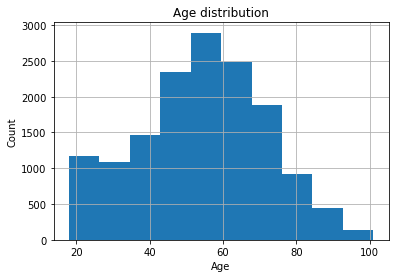

In [43]:
profile_clean.age.hist();
plt.title("Age distribution");
plt.xlabel("Age");
plt.ylabel("Count");

### Transcript

We have to extract offer id, amout, reward from value column.

Fill id for transactions (using previous rows).

In [44]:
def clean_transcript(df_transcript):
    """Clean transcript data
    inputs:
        df_transcript (data frame): transcript data
    outputs:
        df_ret (data frame): cleaned transcript data
    """
    # make copy
    df_ret = df_transcript.copy()
    
    # extract data from value column to multiple columns
    df_ret = pd.concat([df_ret, df_ret['value'].apply(pd.Series)], axis=1)
    
    # fill offer_id with offer id when it's null
    df_ret.offer_id = df_ret.offer_id.fillna(df_ret['offer id'])
    
    # drop value, offer id column
    df_ret.drop(['value','offer id'], axis=1, inplace=True)
    
    # filter dataset for transactions that occur after an offer is viewed
    tmp_transaction = df_ret[['person','event','time','offer_id']].copy()

    # sort by person, time
    tmp_transaction = tmp_transaction.sort_values(['person', 'time'])

    # fill with previous value
    tmp_transaction = tmp_transaction.ffill()
    
    # merge back to df_ret
    df_ret = df_ret.merge(tmp_transaction, how='left', on=['person','event','time'])
    
    # fill offer_id_x with offer_id_y when it's null
    df_ret.offer_id_x = df_ret.offer_id_x.fillna(df_ret['offer_id_y'])
    
    # rename column
    df_ret.rename(columns={'offer_id_x':'offer_id'},inplace=True)
    
    # drop offer_id_y column
    df_ret.drop(['offer_id_y'], axis=1, inplace=True)
    
    return df_ret

In [45]:
transcript_clean = clean_transcript(transcript)

In [46]:
transcript_clean

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...
312641,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,ae264e3637204a6fb9bb56bc8210ddfd,NaN
312642,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,2906b810c7d4411798c6938adc9daaa5,NaN
312643,a00058cf10334a308c68e7631c529907,transaction,714,3.61,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
312644,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN


In [47]:
# check offer_id with transaction event
transcript_clean[transcript_clean.event == 'transaction']

,person,event,time,amount,offer_id,reward
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,ae264e3637204a6fb9bb56bc8210ddfd,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56,2906b810c7d4411798c6938adc9daaa5,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51,5a8bc65990b245e5a138643cd4eb9837,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97,fafdcd668e3743c1bb461111dcafc2a4,NaN
...,...,...,...,...,...,...
312641,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,ae264e3637204a6fb9bb56bc8210ddfd,NaN
312642,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,2906b810c7d4411798c6938adc9daaa5,NaN
312643,a00058cf10334a308c68e7631c529907,transaction,714,3.61,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
312644,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN


#### Create a column indicates a effective offer, then combine with portfolio, profile data

Effective offer: the customer makes the transaction after viewing offer. In other words, the offer need to meet 3 requirements below:

1. User viewed offer.
2. The user performed a transaction after reviewing the offer.
3. The offer happened within the duration.

In [343]:
def create_work_data(transcript_clean, portfolio_clean, profile_clean):
    """
    Combine transcript, portfolio, profile data
    Create a column indicates a effective offer
    
    inputs:
        transcript_clean (data frame): cleaned transcript data
        portfolio_clean (data frame): cleaned portfolio data
        profile_clean (data frame): cleaned profile data
    
    outputs:
        df_ret (data frame)
    """
    # to get offer we need merge with portfolio data
    df_work = pd.merge(transcript_clean,portfolio_clean[['offer_id','duration']],how='left',on='offer_id')
    
    # I want to check if the offer happened within the duration
    # so, i have to convert time (hour) to time (day)
    df_work['time_days'] = df_work['time']/24
    
    # sort by person id and time
    df_work.sort_values(['person', 'time'], inplace=True)
    
    # fill previous offer id (previous row's offer_id)
    df_work['prev_offer_id'] = df_work.groupby(['person'])['offer_id'].shift()

    # fill previous event (previous row's event)
    df_work['prev_event'] = df_work.groupby(['person'])['event'].shift()
    
    # filter event by offer received and transaction
    tmp_diff_time = df_work[(df_work.event=='transaction') | (df_work.event=='offer received')].copy()
    
    # calculate different time from the offer received and a transaction occurs.
    tmp_diff_time['time_diff'] = tmp_diff_time.groupby(['person','offer_id'])['time_days'].diff()
    
    # merge to work data
    df_work = df_work.merge(tmp_diff_time[['person','event','time','offer_id','time_diff']], how='left', on=['person','event','time','offer_id'])
    
    # fill NaN with 0
    df_work.fillna(0, inplace=True)
    
    
    # create effective column base on 3 requirements:
    # User viewed offer.
    # The user performed a transaction after reviewing the offer.
    # The offer happened within the duration.
    df_work['effective'] = np.where((df_work['prev_offer_id']==df_work['offer_id'])\
                                      & (df_work['prev_event']=='offer viewed')\
                                      & (df_work['event']=='transaction')\
                                      & (df_work['time_diff']<=df_work['duration']),1,0)
    
    # get user, offer id list
    user_offer_df = transcript_clean[['person','offer_id']].copy()
    user_offer_df.drop_duplicates(keep='first', inplace=True)
   
    # filter data by effective == 1
    tmp_effective_df = df_work[df_work.effective == 1][['person','offer_id','effective']].copy()
    tmp_effective_df.drop_duplicates(keep='first', inplace=True)
    
    # merge user_offer_df with tmp_effective_df
    df_ret = user_offer_df.merge(tmp_effective_df,how='left',on=['person','offer_id'])
    
    # fill null with 0
    df_ret.effective.fillna(0, inplace=True)

    # merge with portfolio
    df_ret = df_ret.merge(portfolio_clean,how='left',on='offer_id')
    
    # merge with profile
    df_ret = df_ret.merge(profile_clean,how='left',on='person')
    
    # drop row that hasn't user info
    df_ret.dropna(subset=['age'], inplace=True)
    
    return df_ret

In [344]:
df_work_data = create_work_data(transcript_clean, portfolio_clean, profile_clean)

In [345]:
df_work_data

,person,offer_id,effective,reward,difficulty,duration,offer_type,web,email,mobile,social,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,5,5,7,bogo,1,1,1,0,F,75.0,20170509.0,100000.0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0,2,10,7,discount,1,1,1,0,M,68.0,20180426.0,70000.0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1.0,5,5,5,bogo,1,1,1,1,M,65.0,20180209.0,53000.0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0.0,0,0,4,informational,1,1,1,0,M,58.0,20171111.0,51000.0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5,20,10,discount,1,1,0,0,F,61.0,20170911.0,57000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65014,f653cf2d8bba42d0a53c2937ee2e5893,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,5,7,bogo,1,1,1,0,M,64.0,20180104.0,51000.0
65016,670626b55bfb4ba39c85b27cc7cca527,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,5,20,10,discount,1,1,0,0,M,21.0,20160511.0,39000.0
65017,a57890c3bbb7463e9018abb7fecadb15,5a8bc65990b245e5a138643cd4eb9837,1.0,0,0,3,informational,0,1,1,1,M,57.0,20180110.0,77000.0
65018,d087c473b4d247ccb0abfef59ba12b0e,ae264e3637204a6fb9bb56bc8210ddfd,1.0,10,10,7,bogo,0,1,1,1,M,56.0,20161023.0,51000.0


## 3. Feature Engineering <a name="FeatureEngineering"></a>

#### Create columns that indicate how many days that a user is a member (member_days), how many times a user received an offer (offer_rev_cnt)

In [346]:
import datetime
def add_feature(df, transcript_clean):
    ''' Create columns that indicate how many days that a user is a member
         how many times a user received an offer (offer_rev_cnt)
    inputs:
        df (data frame): combined data
        transcript_clean (data frame): transcript data
    outputs:
        df (data frame): add 2 columns member_days and offer_rev_cnt
    
    '''
    tmp_current_date = str(df.became_member_on.max() + 1)
    current_date = datetime.date(int(tmp_current_date[:4]), int(tmp_current_date[4:6]), int(tmp_current_date[6:8]))

    def create_member_days(became_member_on):
        year = int(became_member_on[:4])
        month = int(became_member_on[4:6])
        day = int(became_member_on[6:8])
        
        tmp_date = datetime.date(year, month, day)
        
        return (current_date - tmp_date).days
    
    # add member_days column
    df['member_days'] = df.apply(lambda row: create_member_days(str(row['became_member_on'])),axis=1)
       
    # drop became_member_on column
    df.drop(['became_member_on'], axis=1, inplace=True)
    
    # how many times a user received an offer 
    tmp_cnt=transcript_clean[transcript_clean.event=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()
    
    # rename
    tmp_cnt.rename(columns={'event':'offer_rev_cnt'},inplace=True)

    # count
    tmp_cnt=tmp_cnt.groupby(['person','offer_id']).sum().reset_index()
    
    # merge count data to df_work
    df = df.merge(tmp_cnt[['person','offer_id','offer_rev_cnt']], how='left', on=['person','offer_id'])
    
    # remove records that haven't offer_rev_cnt data
    df.dropna(subset=['offer_rev_cnt'], inplace=True)
    
    return df

In [347]:
df_work_data = add_feature(df_work_data, transcript_clean)

In [348]:
df_work_data

,person,offer_id,effective,reward,difficulty,duration,offer_type,web,email,mobile,social,gender,age,income,member_days,offer_rev_cnt
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,5,5,7,bogo,1,1,1,0,F,75.0,100000.0,444,1.0
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0,2,10,7,discount,1,1,1,0,M,68.0,70000.0,92,1.0
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1.0,5,5,5,bogo,1,1,1,1,M,65.0,53000.0,168,2.0
3,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0.0,0,0,4,informational,1,1,1,0,M,58.0,51000.0,258,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5,20,10,discount,1,1,0,0,F,61.0,57000.0,319,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56746,f653cf2d8bba42d0a53c2937ee2e5893,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,5,7,bogo,1,1,1,0,M,64.0,51000.0,204,1.0
56747,670626b55bfb4ba39c85b27cc7cca527,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,5,20,10,discount,1,1,0,0,M,21.0,39000.0,807,1.0
56748,a57890c3bbb7463e9018abb7fecadb15,5a8bc65990b245e5a138643cd4eb9837,1.0,0,0,3,informational,0,1,1,1,M,57.0,77000.0,198,1.0
56749,d087c473b4d247ccb0abfef59ba12b0e,ae264e3637204a6fb9bb56bc8210ddfd,1.0,10,10,7,bogo,0,1,1,1,M,56.0,51000.0,642,1.0


## 4. Data Modeling <a name="DataModeling"></a>

Because we have 3 types of offer, I'm going to create 3 different models (1 model for each type of offer) to predict that user make a purchase or not. It is in fact a supervised learning model of binary classification.

### Preparation

#### Split data to 3 sets: bogo, discount and informational

In [349]:
def split_data(df):
    ''' Split data to 3 sets: bogo, discount and informational
    inputs:
        df (data frame): combined data
    outputs:
        df_bogo (data frame): bogo
        df_discount (data frame): discount
        df_informational (data frame): informational
    
    '''
    # bogo
    df_bogo = df[df.offer_type == 'bogo'].drop(columns = ['offer_type'],inplace=False,axis=1)
    
    # discount
    df_discount = df[df.offer_type == 'discount'].drop(columns = ['offer_type'],inplace=False,axis=1)
    
    # informational
    df_informational = df[df.offer_type == 'informational'].drop(columns = ['offer_type'],inplace=False,axis=1)
    
    return df_bogo, df_discount, df_informational

In [350]:
df_bogo, df_discount, df_informational = split_data(df_work_data)

#### Create new columns from gender column

In [351]:
def create_dummy_columns(df):
    ''' Create dummy columns from gender column
    inputs:
        df (data frame): combined data
    outputs:
        df (data frame): add dummy columns
    
    '''
    # gender
    df = pd.concat([df[:],pd.get_dummies(df.gender,prefix='gender')],axis=1)
    
    # because we only have 3 types of gender: M, F, O
    # -> keep 2 columns: M, F
    df.drop(['gender', 'gender_O'], axis=1, inplace=True)
    
    return df

In [352]:
# bogo
df_bogo = create_dummy_columns(df_bogo)

# discount
df_discount = create_dummy_columns(df_discount)

# informational
df_informational = create_dummy_columns(df_informational)

In [353]:
df_bogo

,person,offer_id,effective,reward,difficulty,duration,web,email,mobile,social,age,income,member_days,offer_rev_cnt,gender_F,gender_M
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,5,5,7,1,1,1,0,75.0,100000.0,444,1.0,1,0
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1.0,5,5,5,1,1,1,1,65.0,53000.0,168,2.0,0,1
6,4b0da7e80e5945209a1fdddfe813dbe0,ae264e3637204a6fb9bb56bc8210ddfd,1.0,10,10,7,0,1,1,1,64.0,100000.0,321,2.0,0,1
11,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,5,7,1,1,1,0,59.0,41000.0,1283,2.0,0,1
12,1e9420836d554513ab90eba98552d0a9,ae264e3637204a6fb9bb56bc8210ddfd,0.0,10,10,7,0,1,1,1,22.0,70000.0,305,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56741,6e71b66784844d1ab8376ac8ab096d4b,ae264e3637204a6fb9bb56bc8210ddfd,1.0,10,10,7,0,1,1,1,52.0,75000.0,66,1.0,1,0
56742,1966fa40d2f84620b2b1b9b64f8e0209,f19421c1d4aa40978ebb69ca19b0e20d,1.0,5,5,5,1,1,1,1,84.0,93000.0,758,1.0,0,1
56744,97ee6e7a12fe4064b260fa48bdd0330f,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,5,7,1,1,1,0,26.0,55000.0,38,1.0,0,1
56746,f653cf2d8bba42d0a53c2937ee2e5893,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,5,5,7,1,1,1,0,64.0,51000.0,204,1.0,0,1


In [354]:
df_discount

,person,offer_id,effective,reward,difficulty,duration,web,email,mobile,social,age,income,member_days,offer_rev_cnt,gender_F,gender_M
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0,2,10,7,1,1,1,0,68.0,70000.0,92,1.0,0,1
4,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5,20,10,1,1,0,0,61.0,57000.0,319,1.0,1,0
5,31dda685af34476cad5bc968bdb01c53,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5,20,10,1,1,0,0,62.0,71000.0,897,1.0,1,0
8,d53717f5400c4e84affdaeda9dd926b3,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,5,20,10,1,1,0,0,88.0,53000.0,435,2.0,1,0
9,f806632c011441378d4646567f357a21,fafdcd668e3743c1bb461111dcafc2a4,1.0,2,10,10,1,1,1,1,42.0,69000.0,1811,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56739,e340cbf00a914f0c958577c0af36ed8a,2906b810c7d4411798c6938adc9daaa5,0.0,2,10,7,1,1,1,0,52.0,34000.0,109,1.0,0,1
56743,ff737c250d2343729ade04c4f6eb1001,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5,20,10,1,1,0,0,72.0,65000.0,1210,1.0,1,0
56745,bf3069b178fe40d789dd027901bc406b,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,5,20,10,1,1,0,0,59.0,63000.0,361,1.0,1,0
56747,670626b55bfb4ba39c85b27cc7cca527,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,5,20,10,1,1,0,0,21.0,39000.0,807,1.0,0,1


In [355]:
df_informational

,person,offer_id,effective,reward,difficulty,duration,web,email,mobile,social,age,income,member_days,offer_rev_cnt,gender_F,gender_M
3,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0.0,0,0,4,1,1,1,0,58.0,51000.0,258,1.0,0,1
7,c27e0d6ab72c455a8bb66d980963de60,3f207df678b143eea3cee63160fa8bed,1.0,0,0,4,1,1,1,0,78.0,71000.0,406,2.0,1,0
21,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,1.0,0,0,3,0,1,1,1,39.0,51000.0,1522,1.0,0,1
33,a5a6ef2b78a04ddc9f374dd7c7f60bff,5a8bc65990b245e5a138643cd4eb9837,1.0,0,0,3,0,1,1,1,75.0,52000.0,971,1.0,0,1
42,6e04a90a0e074496b5f229eb1f553433,5a8bc65990b245e5a138643cd4eb9837,1.0,0,0,3,0,1,1,1,27.0,35000.0,198,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56728,9bb80ca554284a1ea6abd85a101b4da5,3f207df678b143eea3cee63160fa8bed,1.0,0,0,4,1,1,1,0,74.0,106000.0,699,1.0,1,0
56733,daad151d84664dd6a4809ab8f05af690,5a8bc65990b245e5a138643cd4eb9837,0.0,0,0,3,0,1,1,1,40.0,86000.0,730,1.0,0,1
56738,e9d127cf3f794ccbaac940f93c15ce8c,3f207df678b143eea3cee63160fa8bed,0.0,0,0,4,1,1,1,0,43.0,72000.0,126,1.0,0,1
56740,10316535e185400fb093c371d62254e3,3f207df678b143eea3cee63160fa8bed,0.0,0,0,4,1,1,1,0,54.0,51000.0,1278,1.0,0,1


#### Split data to input and output (label)

In [356]:
def split_input_output(df):
    ''' Split data to input and output (label)
    inputs:
        df (data frame): combined data
    outputs:
        df_input (data frame): input
        df_output (data frame): effective offer or not
    '''
    # output
    df_output = df['effective']
    
    # input
    df_input = df.drop(columns = ['person','offer_id','effective'],inplace=False,axis=1)
    return df_input, df_output

In [357]:
# bogo
bogo_X, bogo_Y = split_input_output(df_bogo)

In [358]:
# discount
discount_X, discount_Y = split_input_output(df_discount)

In [359]:
# informational
info_X, info_Y = split_input_output(df_informational)

#### Split data to train + test

In [360]:
# bogo
bogo_X_train, bogo_X_test, bogo_Y_train, bogo_Y_test = train_test_split(bogo_X, bogo_Y, random_state=42)

In [361]:
# discount
discount_X_train, discount_X_test, discount_Y_train, discount_Y_test = train_test_split(discount_X, discount_Y, random_state=42)

In [362]:
# informational
info_X_train, info_X_test, info_Y_train, info_Y_test = train_test_split(info_X, info_Y, random_state=42)

###  Model Implementation

I will try to use 3 algorithms to find which is best ft for this case:

DecisionTreeClassifier

RandomForestClassifier

AdaBoostClassifier

I decided to focus to the F1 score as a measure to evaluate the model. The reason is that I want to avoid predicting false negatives, such as: It is good if we send someone an offer, but we predict false.

In [363]:
def evaluate_model(model, X_test, Y_test):
    """test model with test data and print classification_report result
    inputs:
        model: the scikit-learn fitted model
        X_text (dataframe): input test set
        Y_test (dataframe): output test set
    outputs:
        report: classification_report
    """
    # using model to predict
    y_pred = model.predict(X_test)

    # print report
    report = classification_report(Y_test, y_pred)
    print(report)
    return report

In [364]:
def build_model(algorithm = 'DecisionTreeClassifier'):
    """create model 
    inputs:
        algorithm (string): default = DecisionTreeClassifier
    outputs:
        pipe (scikit-learn pipline): pipline
    """
    # create pipline 
    if algorithm == 'RandomForestClassifier':
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', RandomForestClassifier())
        ])
    elif algorithm == 'AdaBoostClassifier':
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', AdaBoostClassifier())
        ])
    else:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', DecisionTreeClassifier())
        ]) 
    
    return pipe

In [366]:
def create_evaluate_model(X_train, Y_train, X_test, Y_test, algorithm = 'DecisionTreeClassifier'):
    """build a model then train and evaluate
    inputs:
        X_train (dataframe): input train set
        Y_train (dataframe): output train set
        X_text (dataframe): input test set
        Y_test (dataframe): output test set
        algorithm (string): default = DecisionTreeClassifier
    outputs:
        model (scikit-learn model)
        report: classification_report
    """
    # create model
    model = build_model(algorithm)
    
    # train
    model.fit(X_train, Y_train)
    
    # evaluate
    report = evaluate_model(model, X_test, Y_test)
    
    return model, report

#### DecisionTreeClassifier

In [367]:
# bogo
bogo_dtc, _ = create_evaluate_model(bogo_X_train, bogo_Y_train, bogo_X_test, bogo_Y_test, 'DecisionTreeClassifier')

              precision    recall  f1-score   support

         0.0       0.50      0.51      0.50      2005
         1.0       0.72      0.70      0.71      3511

    accuracy                           0.63      5516
   macro avg       0.61      0.61      0.61      5516
weighted avg       0.64      0.63      0.63      5516



In [368]:
# discount
discount_dtc, _ = create_evaluate_model(discount_X_train, discount_Y_train, discount_X_test, discount_Y_test, 'DecisionTreeClassifier')

              precision    recall  f1-score   support

         0.0       0.62      0.63      0.62      2531
         1.0       0.68      0.67      0.68      2999

    accuracy                           0.65      5530
   macro avg       0.65      0.65      0.65      5530
weighted avg       0.65      0.65      0.65      5530



In [369]:
# info
info_dtc, _ = create_evaluate_model(info_X_train, info_Y_train, info_X_test, info_Y_test, 'DecisionTreeClassifier')

              precision    recall  f1-score   support

         0.0       0.67      0.64      0.65      1612
         1.0       0.52      0.56      0.54      1149

    accuracy                           0.61      2761
   macro avg       0.60      0.60      0.60      2761
weighted avg       0.61      0.61      0.61      2761



#### RandomForestClassifier

In [370]:
# bogo
bogo_rfc, _ = create_evaluate_model(bogo_X_train, bogo_Y_train, bogo_X_test, bogo_Y_test, 'RandomForestClassifier')

              precision    recall  f1-score   support

         0.0       0.57      0.51      0.54      2005
         1.0       0.74      0.78      0.76      3511

    accuracy                           0.68      5516
   macro avg       0.65      0.65      0.65      5516
weighted avg       0.68      0.68      0.68      5516



In [371]:
# discount
discount_rfc, _ = create_evaluate_model(discount_X_train, discount_Y_train, discount_X_test, discount_Y_test, 'RandomForestClassifier')

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      2531
         1.0       0.73      0.73      0.73      2999

    accuracy                           0.71      5530
   macro avg       0.70      0.70      0.70      5530
weighted avg       0.71      0.71      0.71      5530



In [372]:
# info
info_rfc, _ = create_evaluate_model(info_X_train, info_Y_train, info_X_test, info_Y_test, 'RandomForestClassifier')

              precision    recall  f1-score   support

         0.0       0.70      0.74      0.71      1612
         1.0       0.60      0.55      0.57      1149

    accuracy                           0.66      2761
   macro avg       0.65      0.64      0.64      2761
weighted avg       0.65      0.66      0.65      2761



#### AdaBoostClassifier

In [376]:
# bogo
bogo_ada, _ = create_evaluate_model(bogo_X_train, bogo_Y_train, bogo_X_test, bogo_Y_test, 'AdaBoostClassifier')

              precision    recall  f1-score   support

         0.0       0.63      0.44      0.52      2005
         1.0       0.73      0.85      0.79      3511

    accuracy                           0.70      5516
   macro avg       0.68      0.65      0.65      5516
weighted avg       0.69      0.70      0.69      5516



In [377]:
# discount
discount_ada, _ = create_evaluate_model(discount_X_train, discount_Y_train, discount_X_test, discount_Y_test, 'AdaBoostClassifier')

              precision    recall  f1-score   support

         0.0       0.72      0.65      0.68      2531
         1.0       0.73      0.79      0.76      2999

    accuracy                           0.73      5530
   macro avg       0.73      0.72      0.72      5530
weighted avg       0.73      0.73      0.72      5530



In [378]:
# info
info_ada, _ = create_evaluate_model(info_X_train, info_Y_train, info_X_test, info_Y_test, 'AdaBoostClassifier')

              precision    recall  f1-score   support

         0.0       0.68      0.77      0.72      1612
         1.0       0.61      0.50      0.55      1149

    accuracy                           0.66      2761
   macro avg       0.64      0.63      0.63      2761
weighted avg       0.65      0.66      0.65      2761



##### AdaBoostClassifier seems to have the best F1-score. I will stick with this model.

In [381]:
features_list = bogo_X_train.columns
def show_importance_plot(model, features_list, title = 'Importance feature'):
    """Show importance feature plot
    inputs:
        model (scikit-learn model): trained model
        features_list (list): features name 
        title (String): plot's title, default: Feature importance
    """
    importances = pd.DataFrame(model.named_steps['clf'].feature_importances_,
                                index = features_list,
                                columns=['importance']).sort_values('importance',ascending=True)
    # barh plot
    importances.plot.barh()
    
    #title
    plt.title(title)
    plt.show();

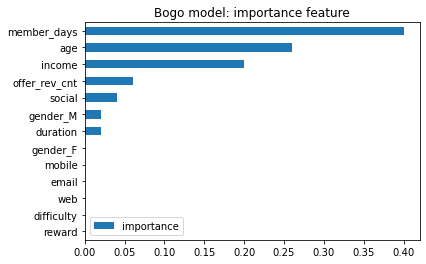

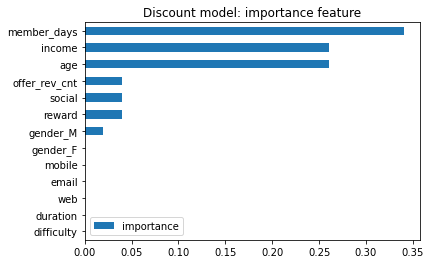

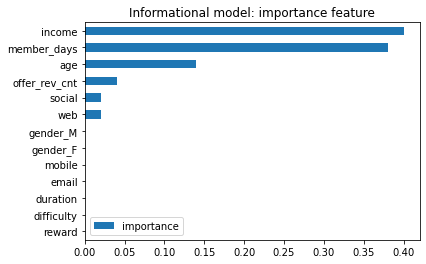

In [382]:
# show plot for bogo 
show_importance_plot(bogo_ada, features_list, 'Bogo model: importance feature')
# show plot for discount 
show_importance_plot(discount_ada, features_list, 'Discount model: importance feature')
# show plot for informational 
show_importance_plot(info_ada, features_list, 'Informational model: importance feature')

The length of membership is the most crucial aspect in determining whether or not the offer will be accepted. That is, the longer a client has been a Starbucks member, the more likely he or she is to respond to an offer. The second and third most important criteria that influence a customer's likelihood of responding are age and income.

#### Tuning AdaBoostClassifier model

In [396]:
def tuning_evaluate_model(model, X_train, Y_train, X_test, Y_test):
    """using GridSearchCV for tuning AdaBoostClassifier model, then evaluate
    inputs:
        model (scikit-learn model)
        X_train (dataframe): input train set
        Y_train (dataframe): output train set
        X_text (dataframe): input test set
        Y_test (dataframe): output test set
    outputs:
        model (scikit-learn model)
        report: classification_report
    """
    parameters =  {'clf__learning_rate': [0.5, 1.0, 1.5, 2.0],
                   'clf__n_estimators':[25, 50, 75, 100]}
    # grid search
    cv = GridSearchCV(estimator=model, param_grid=parameters, scoring='f1_weighted')
    
    # train
    model.fit(X_train, Y_train)
    
    # evaluate
    report = evaluate_model(model, X_test, Y_test)
    
    return model, report

In [397]:
# bogo
cv_bogo, _ = tuning_evaluate_model(bogo_ada, bogo_X_train, bogo_Y_train, bogo_X_test, bogo_Y_test)

              precision    recall  f1-score   support

         0.0       0.63      0.44      0.52      2005
         1.0       0.73      0.85      0.79      3511

    accuracy                           0.70      5516
   macro avg       0.68      0.65      0.65      5516
weighted avg       0.69      0.70      0.69      5516



In [399]:
# discount
cv_discount, _ = tuning_evaluate_model(discount_ada, discount_X_train, discount_Y_train, discount_X_test, discount_Y_test)

              precision    recall  f1-score   support

         0.0       0.72      0.65      0.68      2531
         1.0       0.73      0.79      0.76      2999

    accuracy                           0.73      5530
   macro avg       0.73      0.72      0.72      5530
weighted avg       0.73      0.73      0.72      5530



In [400]:
# info
cv_info, _ = tuning_evaluate_model(info_ada, info_X_train, info_Y_train, info_X_test, info_Y_test)

              precision    recall  f1-score   support

         0.0       0.68      0.77      0.72      1612
         1.0       0.61      0.50      0.55      1149

    accuracy                           0.66      2761
   macro avg       0.64      0.63      0.63      2761
weighted avg       0.65      0.66      0.65      2761



After tuning:

Bogo model has a 70% accuracy rate and a 69% F1 score.

Discount model has a 73% accuracy rate and a 72% F1 score.

Infomational has a 66% accuracy rate and a 65% F1 score.

The accuracy rate didn't change, but in terms of business, I believe it is a good accuracy rate, and it is acceptable in this project.

## 5. Conclusion <a name="Conclusion"></a>

Based on the project's findings, I believe we can apply a machine learning model to predict whether or not a customer will accept the offer. The best model also tells us the most important factors that influence the likelihood of customers responding to the offer, such as membership term, age, and income.

1. What factors have a major impact on the use of a offer?

> The length of membership is the most crucial aspect in determining whether or not the offer will be accepted. That is, the longer a client has been a Starbucks member, the more likely he or she is to respond to an offer. The second and third most important criteria that influence a customer's likelihood of responding are age and income.

2. Is it possible to create a model that predicts whether or not someone will accept an offer based on demographic data?

> We can build a model that predicts whether or not someone will respond to an offer. The accuracy is greater than 60%  for all three models, in terms of business, I think that it is a good accuracy rate, and it is acceptable in this project.

### Next step
In this project, I discarded any records that lacked demographic data.
We lost data from 12% of our users. I believe that if i can find a way to keep such data from being lost, the accuracy will improve.  For example, probably, we can fill null with median.

I could add more features, or I could test removing some features to see how they effect the model's performance.

I didn't look at some demographic groups to see if they would buy even if they didn't get an offer. From a commercial standpoint, we wouldn't send a buy $10 get $2 off offer to a consumer who is already planning to make a $10 purchase without an offer.

In addition, I believe we can test alternative algothrim to see which will fit our data the best.

If I have enough time, I'll create a website that generates a prediction result after entering the customer's information and the offer's details.